## Import python packages

In [1]:
import requests
import json
from pprint import pprint
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

## Parameters

In [18]:
# Which company do you wish to track?
ticker = 'AAPL'

# An email address needs to be included in the URL of the API
email_address = 'your-email@example.com'  

## Find the CIK number for the chosen stock ticker

### Query the sec.gov API

In [3]:
# Run the API request   
request_info = (
    requests
    .get('https://sec.gov/files/company_tickers_exchange.json')
)

# Print the returned status code (200 is good, 404 is bad)
print("Request status code:", request_info.status_code)
print("Content Type:", request_info.headers['Content-Type'])
print("Content Length:", request_info.headers['Content-Length'], 
      'bytes')

Request status code: 200
Content Type: application/json
Content Length: 214545 bytes


In [4]:
# Convert json data to Python dict format
request_data = request_info.json()

### Explore the data that was returned

In [5]:
# List the dictionary keys 
print("request_data:", request_data.keys())

request_data: dict_keys(['fields', 'data'])


In [6]:
request_data['fields']

['cik', 'name', 'ticker', 'exchange']

In [7]:
request_data['data'][0:10]

[[320193, 'Apple Inc.', 'AAPL', 'Nasdaq'],
 [789019, 'MICROSOFT CORP', 'MSFT', 'Nasdaq'],
 [1018724, 'AMAZON COM INC', 'AMZN', 'Nasdaq'],
 [1067983, 'BERKSHIRE HATHAWAY INC', 'BRK-B', 'NYSE'],
 [731766, 'UNITEDHEALTH GROUP INC', 'UNH', 'NYSE'],
 [34088, 'EXXON MOBIL CORP', 'XOM', 'NYSE'],
 [200406, 'JOHNSON & JOHNSON', 'JNJ', 'NYSE'],
 [104169, 'Walmart Inc.', 'WMT', 'NYSE'],
 [19617, 'JPMORGAN CHASE & CO', 'JPM', 'NYSE'],
 [93410, 'CHEVRON CORP', 'CVX', 'NYSE']]

### Create a Pandas dataframe from the API content

In [8]:
# Create a new dataframe
df_tickers = (
    pd.DataFrame(data=request_data['data'], 
                 columns=request_data['fields'])
    .set_index('ticker')
)

# Display the top few rows
df_tickers.head()

,cik,name,exchange
ticker,,,
AAPL,320193,Apple Inc.,Nasdaq
MSFT,789019,MICROSOFT CORP,Nasdaq
AMZN,1018724,AMAZON COM INC,Nasdaq
BRK-B,1067983,BERKSHIRE HATHAWAY INC,NYSE
UNH,731766,UNITEDHEALTH GROUP INC,NYSE


In [9]:
# Slice the dataframe to show only the row where ticker=='AAPL'
df_tickers.query(f"ticker=='{ticker}'")

,cik,name,exchange
ticker,,,
AAPL,320193,Apple Inc.,Nasdaq


### Create a function to pull data for a single ticker and format the CIK as a string

This is necessary because in the next section we will need to add a formatted CID to the API call.

In [10]:
def get_cik_string(ticker_data, ticker_symbol):
    ticker_symbol = ticker_symbol.upper()
    data_slice = ticker_data.loc[[ticker_symbol],['cik']]
    cik_value = data_slice.values[0][0]
    cik_string = 'CIK' + str(cik_value).rjust(10, '0')
    return cik_string

In [11]:
# Example for our ticker
print("ticker:", ticker)
print("CIK:",    get_cik_string(df_tickers, ticker))

ticker: AAPL
CIK: CIK0000320193


## Get financial data from the [data.sec.gov api](https://www.sec.gov/edgar/sec-api-documentation) for a specific [XBRL line item tag](https://xbrl.us/data-rule/dqc_0015-lepr/)

In [22]:
# Build up the request URL
cik = get_cik_string(df_tickers, ticker)
tag = 'Assets'
domain = 'https://data.sec.gov'
url = f"{domain}/api/xbrl/companyconcept/{cik}/us-gaap/{tag}.json"

# Run the API request   
request_tag_data = (requests
                    .get(url, 
                         headers={'User-Agent': email_address})
                   )

# Print the status code (200 is good, 404 is bad)
print("Request status code:", request_tag_data.status_code)
print("Content Type:", request_tag_data.headers['Content-Type'])
print("Content Length:", 
      request_tag_data.headers['Content-Length'], 'bytes')

Request status code: 200
Content Type: application/json
Content Length: 2052 bytes


In [13]:
tag_data = request_tag_data.json()

pprint(tag_data, depth=2)

{'cik': 320193,
 'description': 'Sum of the carrying amounts as of the balance sheet date of '
                'all assets that are recognized. Assets are probable future '
                'economic benefits obtained or controlled by an entity as a '
                'result of past transactions or events.',
 'entityName': 'Apple Inc.',
 'label': 'Assets',
 'tag': 'Assets',
 'taxonomy': 'us-gaap',
 'units': {'USD': [...]}}


In [26]:
df_tag_data = pd.DataFrame.from_dict(tag_data['units']['USD'])
df_tag_data.head(10)

,end,val,accn,fy,fp,form,filed,frame
0,2008-09-27,39572000000,0001193125-09-153165,2009,Q3,10-Q,2009-07-22,NaN
1,2008-09-27,39572000000,0001193125-09-214859,2009,FY,10-K,2009-10-27,NaN
2,2008-09-27,36171000000,0001193125-10-012091,2009,FY,10-K/A,2010-01-25,NaN
3,2008-09-27,36171000000,0001193125-10-238044,2010,FY,10-K,2010-10-27,CY2008Q3I
4,2009-06-27,48140000000,0001193125-09-153165,2009,Q3,10-Q,2009-07-22,CY2009Q2I
5,2009-09-26,53851000000,0001193125-09-214859,2009,FY,10-K,2009-10-27,NaN
6,2009-09-26,47501000000,0001193125-10-012085,2010,Q1,10-Q,2010-01-25,NaN
7,2009-09-26,47501000000,0001193125-10-012091,2009,FY,10-K/A,2010-01-25,NaN
8,2009-09-26,47501000000,0001193125-10-088957,2010,Q2,10-Q,2010-04-21,NaN
9,2009-09-26,47501000000,0001193125-10-162840,2010,Q3,10-Q,2010-07-21,NaN


## Plot trend data

### Create a table of plot data

In [16]:
# Filter rows to only those with current year (CY) labels
starts_with_cy = lambda x: bool(isinstance(re.search(r'^CY', x), re.Match))

x_axis_name = 'End Date'
y_axis_name = f'{tag} (USD in Billions)'

df_plot_data = (
    df_tag_data
    .query("form == '10-Q'")
    .assign(filter_flag = lambda x: [starts_with_cy(str(y)) for y in x.frame])
    .query("filter_flag==True")
    .filter(['end', 'val'])
    .assign(val = lambda x: x.val/1000000000)
    .rename(columns={'end':x_axis_name, 'val':y_axis_name})
    .sort_values(by=x_axis_name)
)

df_plot_data.tail(10)

,End Date,Assets (USD in Billions)
90,2019-06-29,322.239
96,2019-12-28,340.618
97,2020-03-28,320.400
98,2020-06-27,317.344
104,2020-12-26,354.054
105,2021-03-27,337.158
106,2021-06-26,329.840
112,2021-12-25,381.191
113,2022-03-26,350.662
114,2022-06-25,336.309


### Draw a line chart

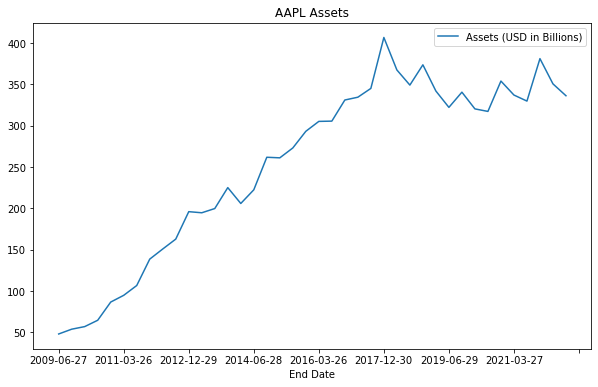

In [20]:
df_plot_data.plot(kind = 'line', x = x_axis_name, y = y_axis_name, 
                  figsize=(10, 6), title = f"{ticker} {tag}")
plt.show()